In [1]:
from pathlib import Path
import warnings, itertools
warnings.filterwarnings("ignore")
import numpy as np, pandas as pd, matplotlib.pyplot as plt
import cartopy.crs as ccrs, cartopy.feature as cfeature
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.model_selection import GroupKFold
from sklearn.metrics import (
    mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error,)
import seaborn as sns
import matplotlib.pyplot as plt
import torch, pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

# Multistage Spatial split 

- **Stage‑1 clustering (K=10)** – divides CONUS counties into primary
   spatial clusters.
- **Stage‑2 clustering (K=4)** – inside each primary cluster
   further splits into sub‑clusters.
- **Multistage CV**
   * Outer loop: hold out an entire primary cluster, train on the rest
   * Inner loop: within the held primary cluster, iteratively hold out
     one sub‑cluster and predict its counties (completely unseen at both
     stages)
- Tracks ELBO loss curves
   * Train ELBO during every epoch.
   * Validation ELBO each epoch on the currently held‑out data (outer
     or inner, depending on stage).
- Computes MAE, RMSE, MAPE, and R² for every inner fold and prints
   mean ± std across primary clusters.
- **Maps**: if `SHOW_MAPS=True`, draws the sub‑cluster layout and
   highlights the current held‑out sub‑cluster, set `SHOW_MAPS=False` to suppress maps

Notes:
- Adjust `N_CLUSTERS` or `N_SUB` to change number of clusters at each step

Is it learning from nearby clusters?
Yes, but only indirectly through feature similarity, not through spatial proximity. If counties in the held primary cluster share feature values with counties in neighbouring clusters (e.g. similar median income and population), the model’s global coefficients will generalise well. **(need to work on this)**


In [2]:
DATA_DIR   = Path("../data/df_clean")
YEARS      = range(2010, 2023)
N_CLUSTERS = 10           # primary clusters
N_SUB      = 4            # sub‑clusters within each primary cluster
EPOCHS_OUT = 1500         # epochs for outer fit
EPOCHS_IN  = 1000         # epochs for optional inner fine‑tune (here skipped)
LR         = 1e-2   
SHOW_MAPS  = True
SEED       = 42           # keeps the same seed every time you rerun    
pyro.set_rng_seed(SEED); np.random.seed(SEED)


CENSUS_MAP = {"E_TOTPOP":"Total Population",
              "E_UNEMP":"Estimated Unemployed",
              "E_LIMENG":"Estimated Limited English Proficiency",
              "E_NOVEH":"Estimated No Vehicle",
              "E_HU":"Estimated Housing Units"
              ,"E_MOBILE":"Estimated Mobile Homes"
              ,"E_CROWD":"Estimated Crowded Housing"
              ,"B19001_001E":"Household Income Distribution"
              ,"B19013_001E":"Median Household Income","LAT":"Latitude"
              ,"LON":"Longitude",
              "DAMAGE_PROPERTY":"Damage to Property"}

FEATURES = ["log_pop","log_medinc","pct_unemp","pct_mobile","pct_crowd"]
TARGET   = "Damage to Property"

In [3]:
def load_all_years(data_dir, years):
    dfs=[]
    for y in years:
        fp=data_dir/f"df_hurricane_{y}.csv"
        if fp.exists():
            df=pd.read_csv(fp).rename(columns=CENSUS_MAP); df["Year"]=y; dfs.append(df)
    if not dfs:
        raise FileNotFoundError("No yearly CSVs found – check DATA_DIR")
    return pd.concat(dfs, ignore_index=True)


def add_features(df):
    eps=1e-6
    df["pct_unemp"]=df["Estimated Unemployed"]/(df["Total Population"]+eps)
    df["pct_mobile"]=df["Estimated Mobile Homes"]/(df["Estimated Housing Units"]+eps)
    df["pct_crowd"]=df["Estimated Crowded Housing"]/(df["Estimated Housing Units"]+eps)
    df["log_pop"]=np.log1p(df["Total Population"].clip(lower=0))
    df["log_medinc"]=np.log1p(df["Median Household Income"].clip(lower=0))
    df.replace([np.inf,-np.inf],np.nan,inplace=True)
    return df.dropna(subset=FEATURES+["Latitude","Longitude",TARGET]).reset_index(drop=True)

In [4]:
def kmeans_labels(coords, k):
    return KMeans(n_clusters=k, random_state=SEED).fit_predict(coords)

# Plotting the inner subclusters
def plot_inner_subclusters(df_cluster, held_sub):
    proj=ccrs.Mercator()
    ax=plt.axes(projection=proj)
    lon,lat=df_cluster["Longitude"], df_cluster["Latitude"]
    ax.set_extent([lon.min()-1, lon.max()+1, lat.min()-1, lat.max()+1], crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.STATES, linewidth=.4)
    scatter=ax.scatter(lon, lat, c=df_cluster["sub"], cmap="tab10", s=18, transform=ccrs.PlateCarree())
    mask=df_cluster["sub"]==held_sub
    ax.scatter(lon[mask], lat[mask], facecolors='none', edgecolors='k', linewidths=1.2, s=60, transform=ccrs.PlateCarree())
    ax.set_title(f"Primary cluster {df_cluster['cluster'].iloc[0]} – held sub {held_sub}")
    plt.colorbar(scatter, ax=ax, shrink=0.6, label="Sub‑cluster ID")
    plt.show()


# Preparing tensors and standardizing them
def tensors(df, scaler=None):
    X=df[FEATURES].values; y=np.log1p(df[TARGET].values)
    scaler=StandardScaler().fit(X) if scaler is None else scaler
    return torch.tensor(scaler.transform(X),dtype=torch.float32), torch.tensor(y,dtype=torch.float32), scaler


def compute_metrics(y_t,y_p):
    return dict(MAE=mean_absolute_error(y_t,y_p), RMSE=np.sqrt(mean_squared_error(y_t,y_p)), MAPE=mean_absolute_percentage_error(y_t,y_p), R2=r2_score(y_t,y_p))


In [5]:
# Pipeline
def model(X,y=None):
    n=X.shape[1]
    beta=pyro.sample("beta",dist.Normal(torch.zeros(n),10.).to_event(1))
    alpha=pyro.sample("alpha",dist.Normal(0.,10.))
    sigma=pyro.sample("sigma",dist.HalfNormal(10.))
    mu=alpha+(X*beta).sum(-1)
    with pyro.plate("obs",X.size(0)):
        pyro.sample("y",dist.Normal(mu,sigma),obs=y)


def guide(X,y=None):
    n=X.shape[1]
    beta_loc=pyro.param("beta_loc",torch.zeros(n)); beta_scale=pyro.param("beta_scale",torch.ones(n),constraint=dist.constraints.positive)
    alpha_loc=pyro.param("alpha_loc",torch.tensor(0.)); alpha_scale=pyro.param("alpha_scale",torch.tensor(1.),constraint=dist.constraints.positive)
    sigma_loc=pyro.param("sigma_loc",torch.tensor(1.),constraint=dist.constraints.positive)
    pyro.sample("beta",dist.Normal(beta_loc,beta_scale).to_event(1))
    pyro.sample("alpha",dist.Normal(alpha_loc,alpha_scale))
    pyro.sample("sigma",dist.HalfNormal(sigma_loc+1e-3))



In [6]:
# Training, prediction and calculating evaluation metrics
def fit_svi(X_train, y_train, X_val=None, y_val=None, epochs=1000):
    """Train model and return epoch‑wise train & (optional) val ELBO lists."""
    pyro.clear_param_store()
    svi=SVI(model, guide, Adam({"lr":LR}), loss=Trace_ELBO())
    tr_loss, val_loss = [], []
    for _ in range(epochs):
        tr_loss.append(svi.step(X_train,y_train))
        if X_val is not None:
            with torch.no_grad():
                val_loss.append(svi.loss(model, guide, X_val, y_val))
    return tr_loss, val_loss


def plot_elbo(tr,val,title):
    plt.figure(figsize=(5,3))
    plt.plot(tr,label="train")
    if val: plt.plot(val,label="val")
    plt.xlabel("epoch"); plt.ylabel("ELBO (‑loss)"); plt.title(title); plt.legend(); plt.tight_layout(); plt.show()

# helper prediction using current params
def predict_fast(df,scaler):
    X,y_true,_=tensors(df,scaler)
    with torch.no_grad():
        alpha=pyro.param("alpha_loc").item(); beta=pyro.param("beta_loc").detach().numpy()
        y_hat=alpha+(X.numpy()@beta)
    return np.expm1(y_hat), np.expm1(y_true.numpy())


In [7]:
# Set up for multistage CV
def multistage_cv(df_primary):
    outer_results=[]
    outer_split=GroupKFold(n_splits=N_CLUSTERS)
    for outer,(train_idx, outer_val_idx) in enumerate(outer_split.split(df_primary, groups=df_primary["cluster"])):
        primary_cluster=df_primary.iloc[outer_val_idx]["cluster"].iloc[0]

        # outer fit
        train_outer=df_primary.iloc[train_idx].copy()
        Xo,yo,scaler_outer=tensors(train_outer)
        X_hold,y_hold,_   = tensors(df_primary.iloc[outer_val_idx], scaler_outer)
        tr_elbo, val_elbo = fit_svi(Xo,yo,X_hold,y_hold,epochs=EPOCHS_OUT)
        plot_elbo(tr_elbo,val_elbo,f"Outer cluster {primary_cluster} ELBO")

        # inner CV
        cluster_df=df_primary.iloc[outer_val_idx].copy()
        cluster_df["sub"] = kmeans_labels(cluster_df[["Latitude","Longitude"]].values, N_SUB)
        inner_split=GroupKFold(n_splits=N_SUB)
        inner_metrics=[]
        for sub,(sub_tr, sub_val) in enumerate(inner_split.split(cluster_df, groups=cluster_df["sub"])):
            if SHOW_MAPS: plot_inner_subclusters(cluster_df, sub)
            y_pred,y_true = predict_fast(cluster_df.iloc[sub_val], scaler_outer)
            m=compute_metrics(y_true,y_pred); inner_metrics.append(m)
            print(f"Outer {primary_cluster} | Sub {sub} → "+", ".join([f"{k}={v:,.2f}" for k,v in m.items()]))
        outer_results.append({k:np.mean([d[k] for d in inner_metrics]) for k in inner_metrics[0]})
    summary={k:(np.mean([d[k] for d in outer_results]), np.std([d[k] for d in outer_results])) for k in outer_results[0]}
    print("\nMultistage CV summary → "+", ".join([f"{k}={mu:,.2f}±{sd:,.2f}" for k,(mu,sd) in summary.items()]))


Running multistage spatial cross‑validation …


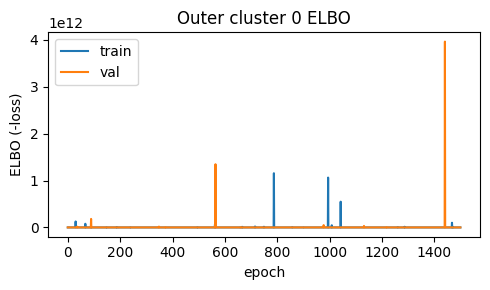

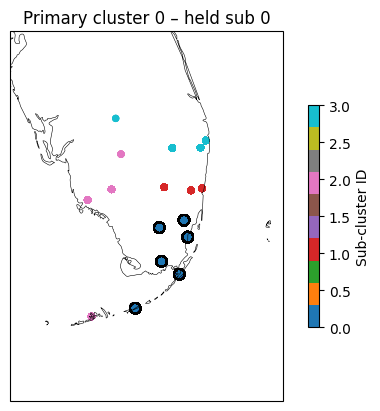

Outer 0 | Sub 0 → MAE=29,622.54, RMSE=126,893.32, MAPE=1,259,874,029,666,304.00, R2=-0.06


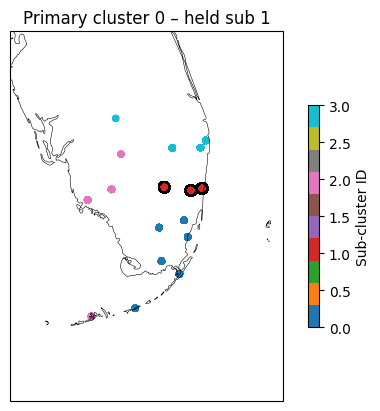

Outer 0 | Sub 1 → MAE=20,179.82, RMSE=84,040.01, MAPE=2,373,945,730,793,472.00, R2=-0.06


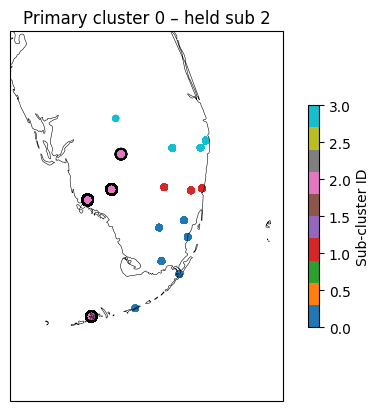

Outer 0 | Sub 2 → MAE=18,734,176.00, RMSE=74,766,771.52, MAPE=2,244,273,688,805,376.00, R2=-0.07


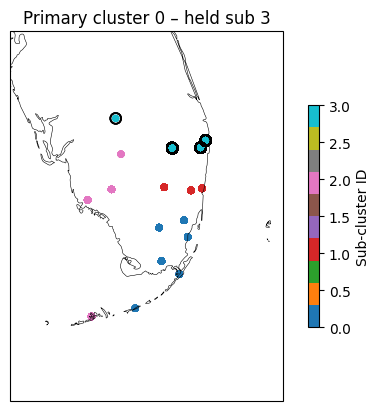

Outer 0 | Sub 3 → MAE=19,044,866.00, RMSE=65,052,448.66, MAPE=4,874,280,537,948,160.00, R2=-0.09


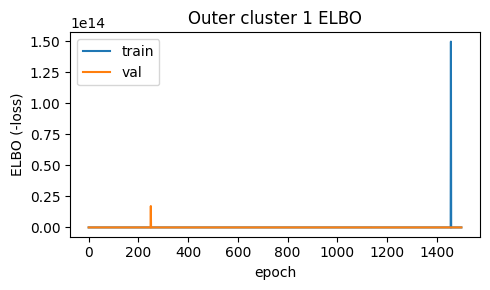

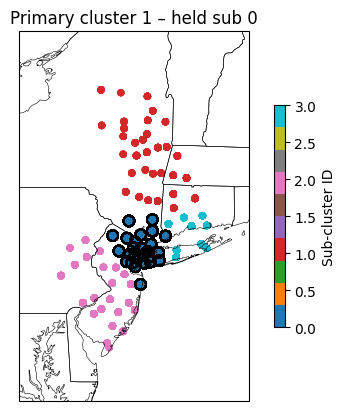

Outer 1 | Sub 0 → MAE=1,017,562.38, RMSE=2,565,904.64, MAPE=4,140,237,609,500,672.00, R2=-0.19


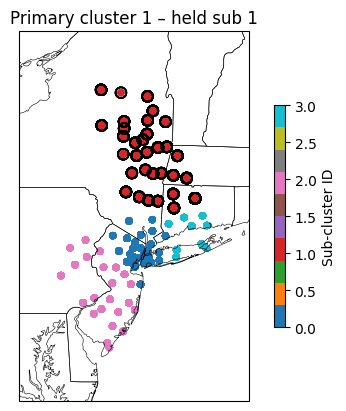

Outer 1 | Sub 1 → MAE=1,120,331.88, RMSE=3,265,614.83, MAPE=5,441,110,457,450,496.00, R2=-0.13


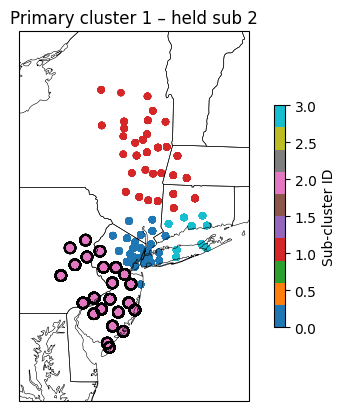

Outer 1 | Sub 2 → MAE=1,319,597.00, RMSE=2,328,057.98, MAPE=6,174,025,151,676,416.00, R2=-0.47


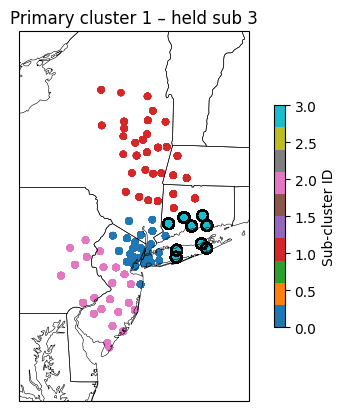

Outer 1 | Sub 3 → MAE=3,006,429.75, RMSE=7,042,115.82, MAPE=81,739,223,417,225,216.00, R2=-0.22


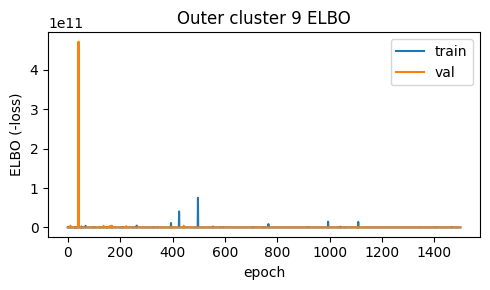

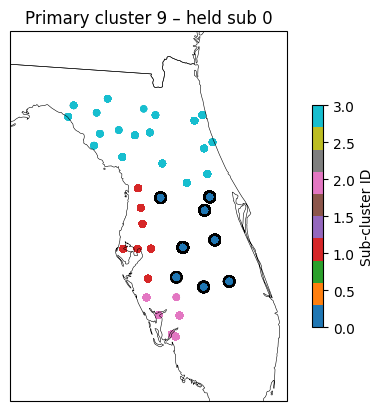

Outer 9 | Sub 0 → MAE=13,784,218.00, RMSE=85,174,136.65, MAPE=22,420,792,289,525,760.00, R2=-0.03


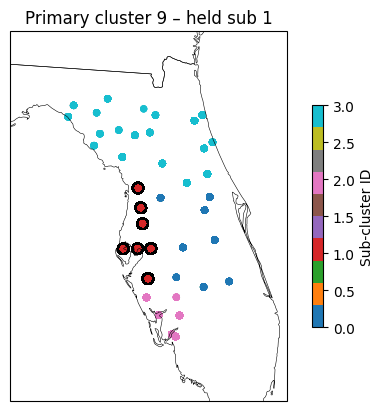

Outer 9 | Sub 1 → MAE=17,461,166.00, RMSE=52,566,896.53, MAPE=24,569,661,064,478,720.00, R2=-0.12


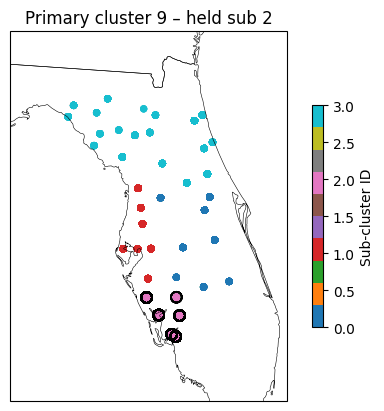

Outer 9 | Sub 2 → MAE=33,082,958.00, RMSE=105,684,222.07, MAPE=37,531,232,413,679,616.00, R2=-0.11


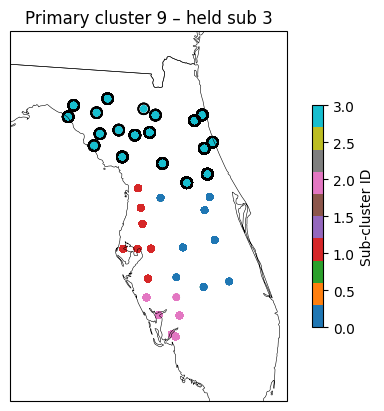

Outer 9 | Sub 3 → MAE=91,362,128.00, RMSE=319,904,302.48, MAPE=168,554,703,041,331,200.00, R2=-0.09


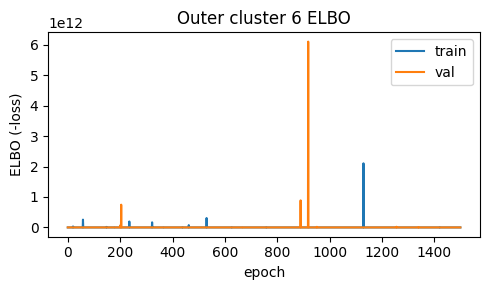

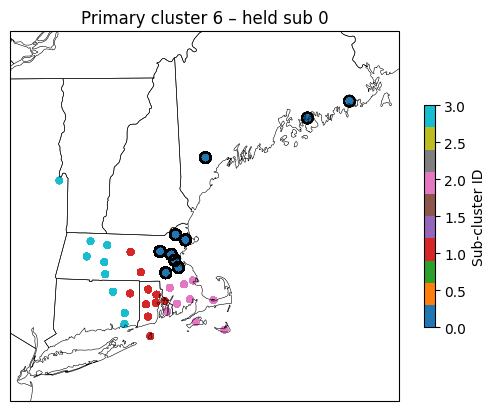

Outer 6 | Sub 0 → MAE=756,730.69, RMSE=1,464,359.92, MAPE=4,980,145,039,343,616.00, R2=-0.36


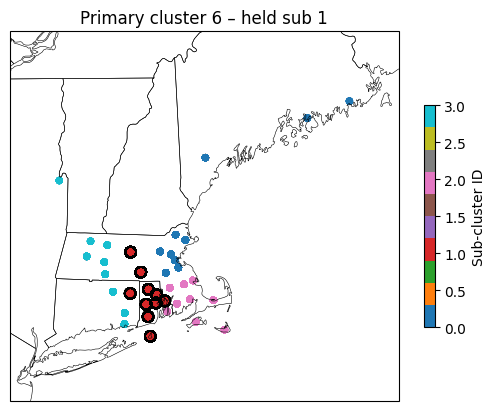

Outer 6 | Sub 1 → MAE=413,530.09, RMSE=965,459.84, MAPE=117,652,290,797,568.00, R2=-0.22


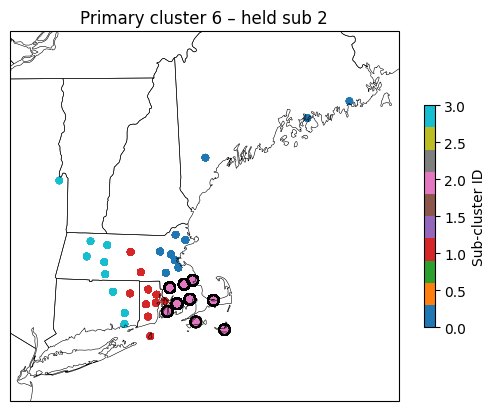

Outer 6 | Sub 2 → MAE=356,801.72, RMSE=2,056,408.28, MAPE=963,143,664,664,576.00, R2=-0.03


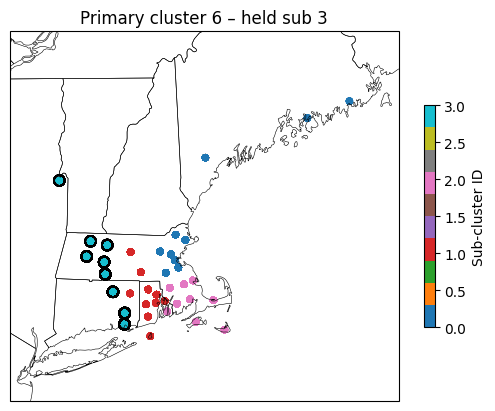

Outer 6 | Sub 3 → MAE=959,211.62, RMSE=3,500,190.63, MAPE=4,892,434,290,966,528.00, R2=-0.08


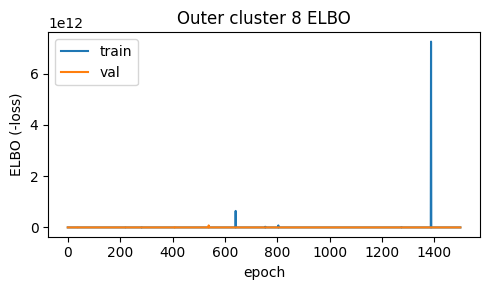

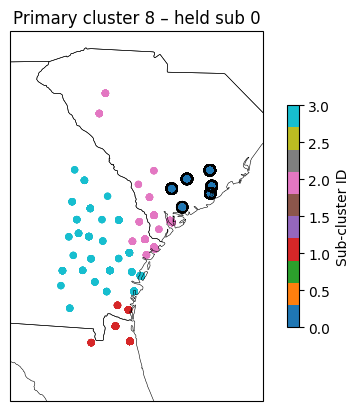

Outer 8 | Sub 0 → MAE=1,730.89, RMSE=4,453.76, MAPE=196,039,229,560,586,240.00, R2=-0.49


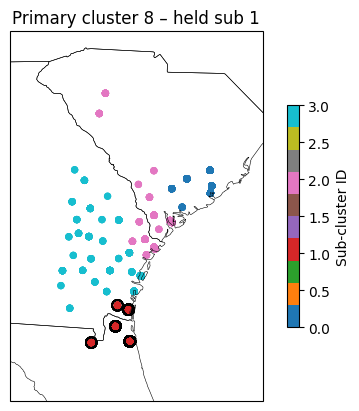

Outer 8 | Sub 1 → MAE=368,011.62, RMSE=1,335,060.54, MAPE=379,373,842,780,389,376.00, R2=-0.08


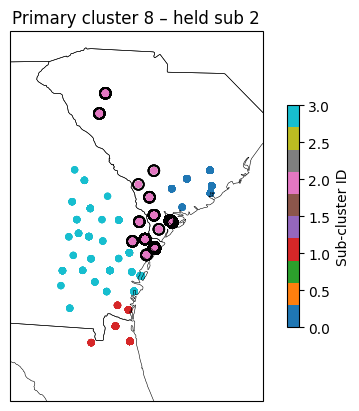

Outer 8 | Sub 2 → MAE=1,120,252.62, RMSE=3,331,089.47, MAPE=197,044,062,929,289,216.00, R2=-0.13


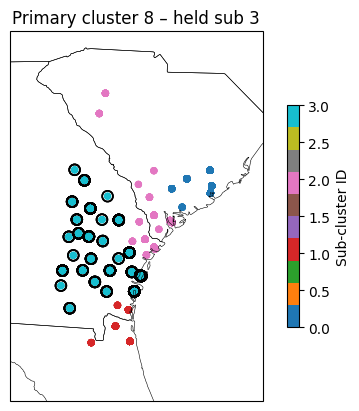

Outer 8 | Sub 3 → MAE=54,037.19, RMSE=193,263.26, MAPE=6,244,393,165,709,639,680.00, R2=-0.07


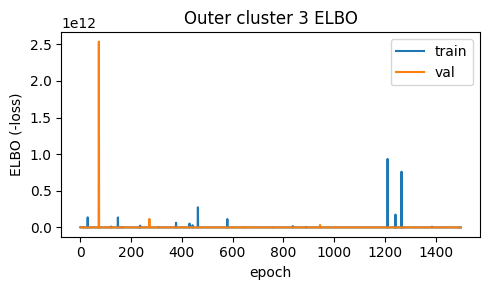

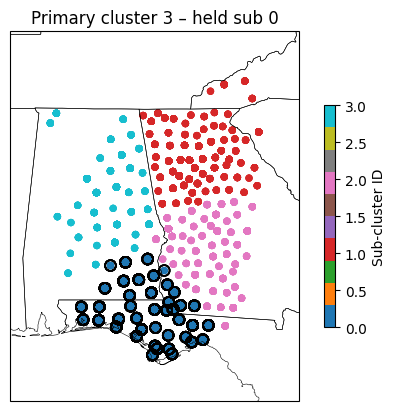

Outer 3 | Sub 0 → MAE=756,130.25, RMSE=2,657,448.29, MAPE=205,593,298,411,192,320.00, R2=-0.09


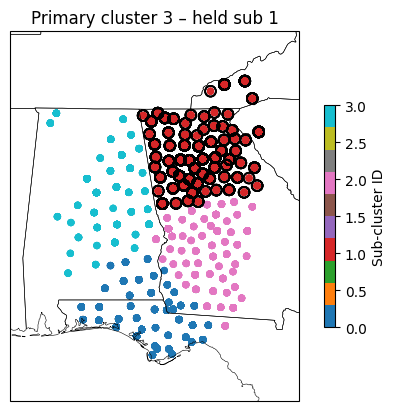

Outer 3 | Sub 1 → MAE=131,398,952.00, RMSE=816,050,861.51, MAPE=40,590,026,517,512,192.00, R2=-0.03


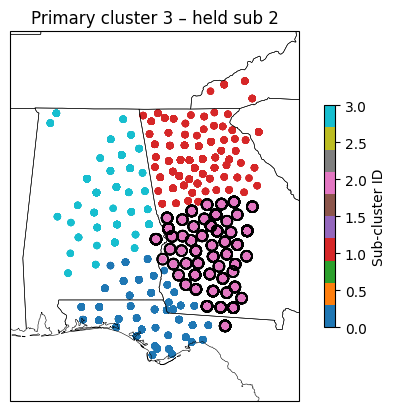

Outer 3 | Sub 2 → MAE=6,985,464.00, RMSE=43,149,109.38, MAPE=444,695,450,629,439,488.00, R2=-0.03


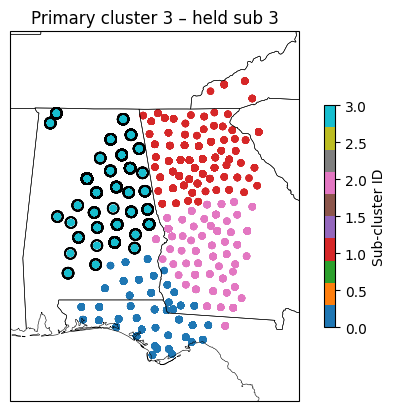

Outer 3 | Sub 3 → MAE=2,401.01, RMSE=19,949.25, MAPE=416,574,856,633,516,032.00, R2=-0.01


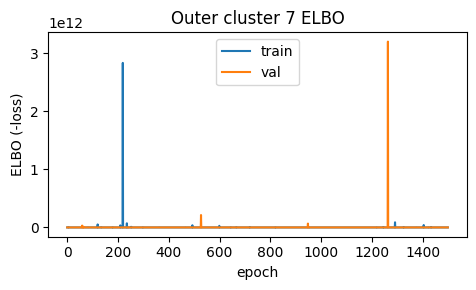

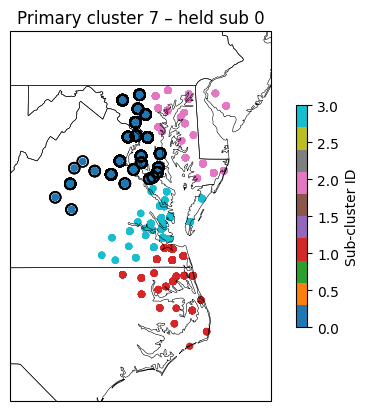

Outer 7 | Sub 0 → MAE=608,389.38, RMSE=1,595,011.65, MAPE=27,635,516,094,545,920.00, R2=-0.17


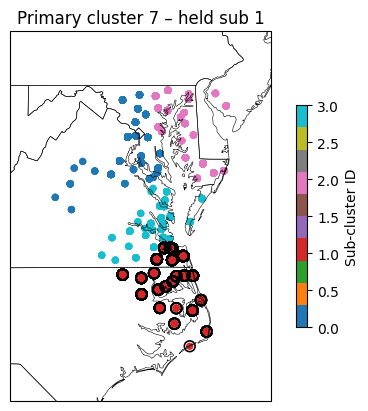

Outer 7 | Sub 1 → MAE=360,071.03, RMSE=799,831.31, MAPE=423,389,118,332,928.00, R2=-0.25


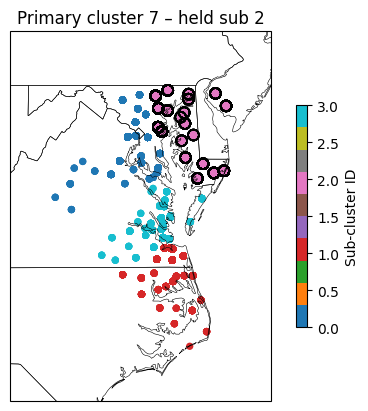

Outer 7 | Sub 2 → MAE=170,092.91, RMSE=212,581.74, MAPE=6,319,221,352,955,904.00, R2=-1.78


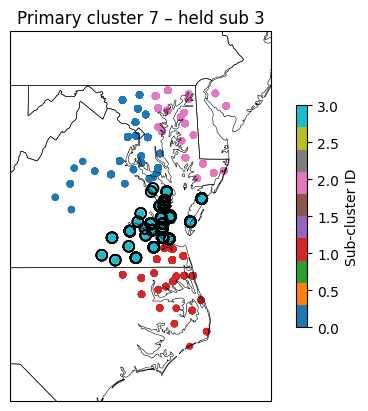

Outer 7 | Sub 3 → MAE=154,101.19, RMSE=454,752.13, MAPE=28,736,425,734,176,768.00, R2=-0.13


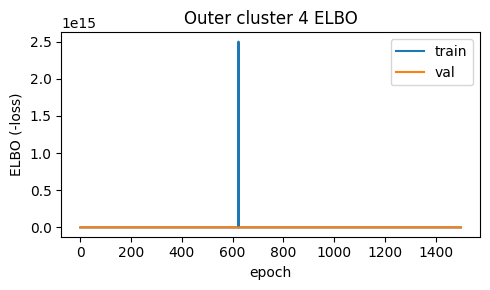

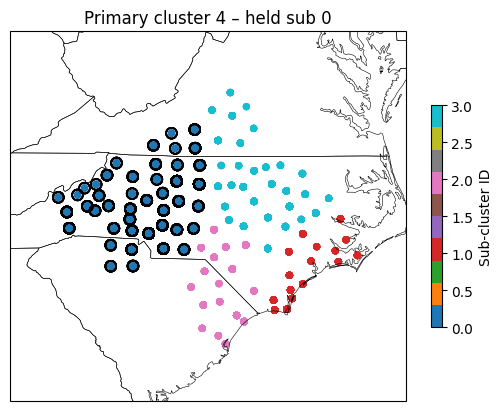

Outer 4 | Sub 0 → MAE=511,178.66, RMSE=1,358,106.71, MAPE=6,307,616,888,193,024.00, R2=-0.17


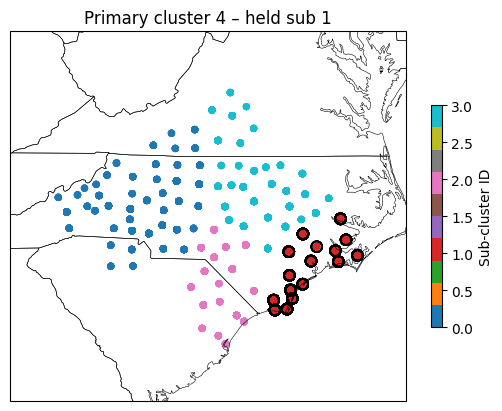

Outer 4 | Sub 1 → MAE=309,784.28, RMSE=637,245.37, MAPE=12,720,981,239,922,688.00, R2=-0.31


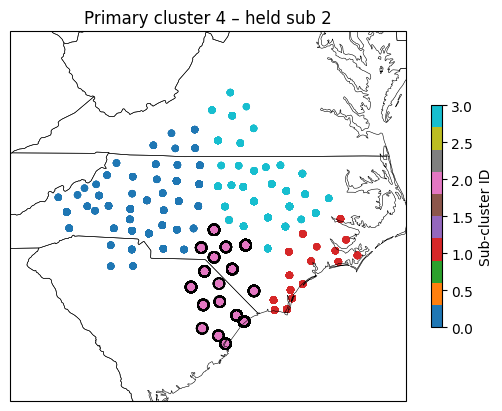

Outer 4 | Sub 2 → MAE=23,220,522.00, RMSE=143,526,929.73, MAPE=152,728,178,052,300,800.00, R2=-0.03


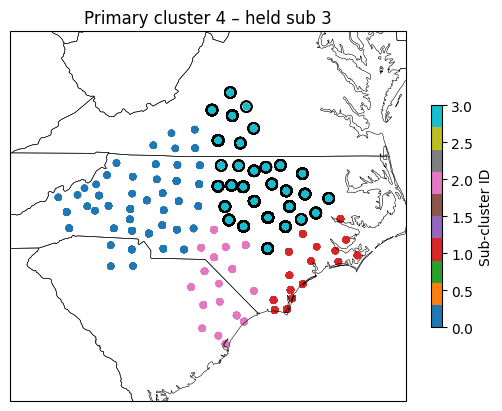

Outer 4 | Sub 3 → MAE=5,772,449.50, RMSE=19,046,021.23, MAPE=17,874,197,892,038,656.00, R2=-0.10


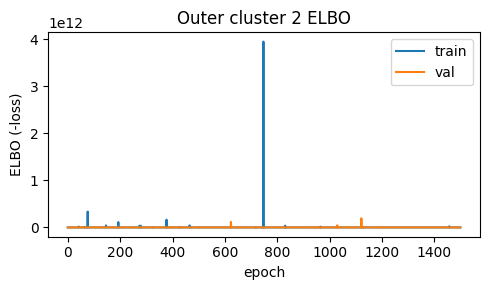

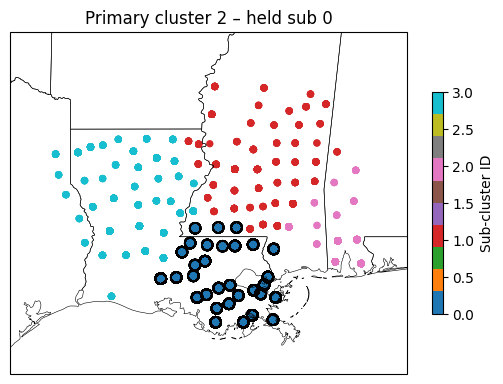

Outer 2 | Sub 0 → MAE=125,291,080.00, RMSE=278,549,849.62, MAPE=34,845,516,349,046,784.00, R2=-0.25


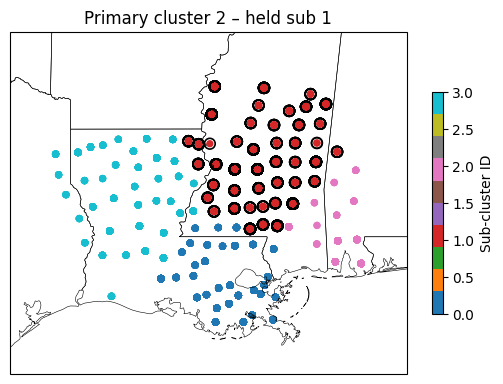

Outer 2 | Sub 1 → MAE=13,073,657.00, RMSE=44,862,422.76, MAPE=54,832,614,812,418,048.00, R2=-0.09


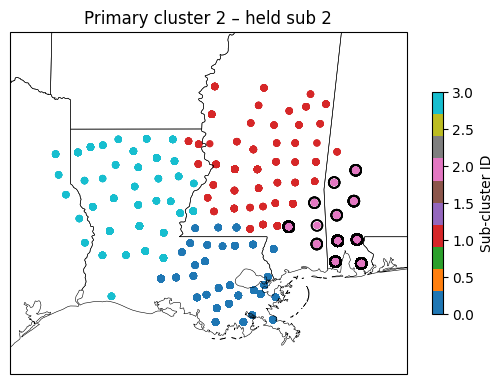

Outer 2 | Sub 2 → MAE=52,190,900.00, RMSE=174,051,537.32, MAPE=255,839,261,813,637,120.00, R2=-0.10


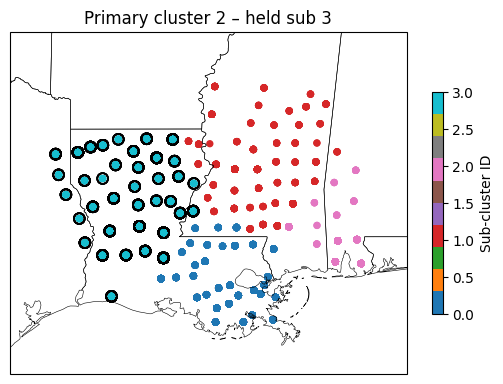

Outer 2 | Sub 3 → MAE=116,448.16, RMSE=227,651.71, MAPE=15,802,909,111,353,344.00, R2=-0.35


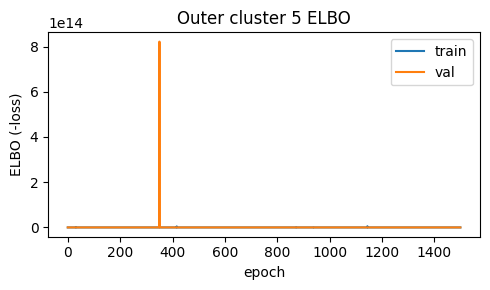

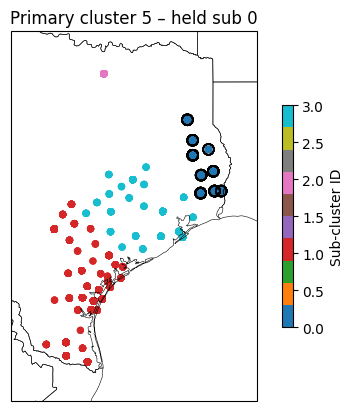

Outer 5 | Sub 0 → MAE=80,433,824.00, RMSE=228,867,560.58, MAPE=1,924,420,226,514,944.00, R2=-0.14


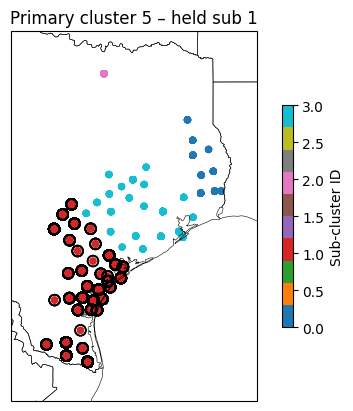

Outer 5 | Sub 1 → MAE=21,221,978.00, RMSE=121,280,388.45, MAPE=2,851,642,462,437,376.00, R2=-0.03


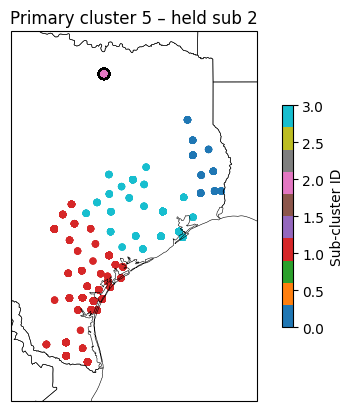

Outer 5 | Sub 2 → MAE=16,169,796.00, RMSE=32,396,978.95, MAPE=18,803,214,350,548,992.00, R2=-0.33


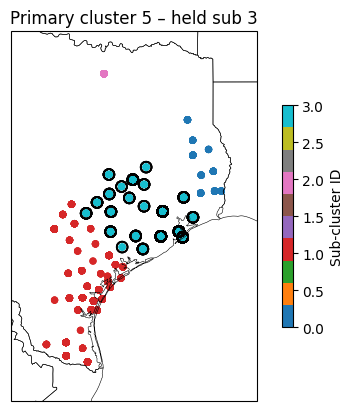

Outer 5 | Sub 3 → MAE=499,999.06, RMSE=499,999.05, MAPE=1.00, R2=-255,999,025,872,896.00

Multistage CV summary → MAE=17,081,519.01±17,614,705.78, RMSE=66,041,398.17±70,877,423.72, MAPE=228,355,644,334,696,032.00±514,563,369,438,483,072.00, R2=-6,399,975,646,822.59±19,199,926,940,467.18


In [8]:
df_all = add_features(load_all_years(DATA_DIR, YEARS))
train_df = df_all[df_all["Year"] < 2022].copy()
train_df["cluster"] = kmeans_labels(train_df[["Latitude","Longitude"]].values, N_CLUSTERS)

print("Running multistage spatial cross‑validation …")
multistage_cv(train_df)

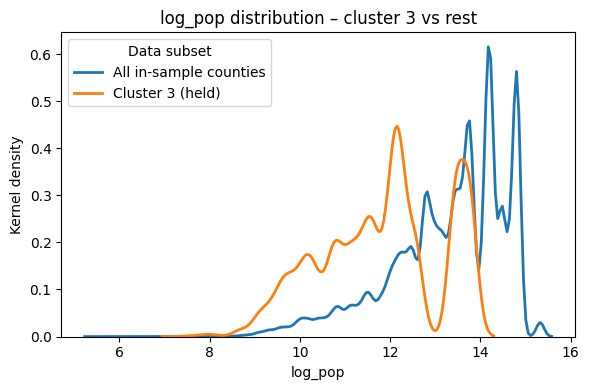

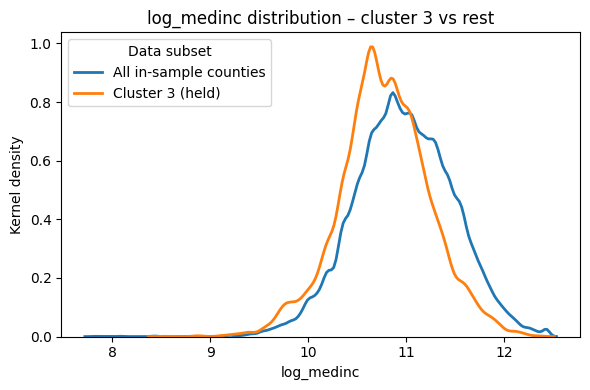

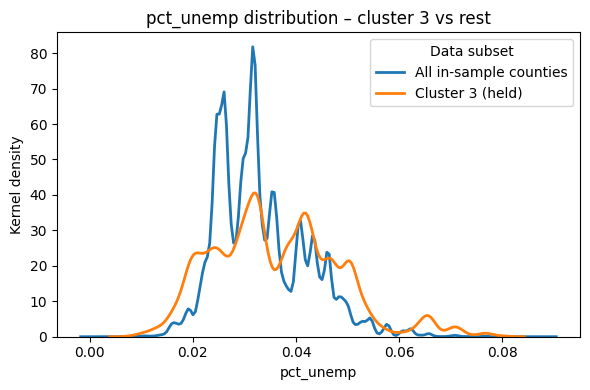

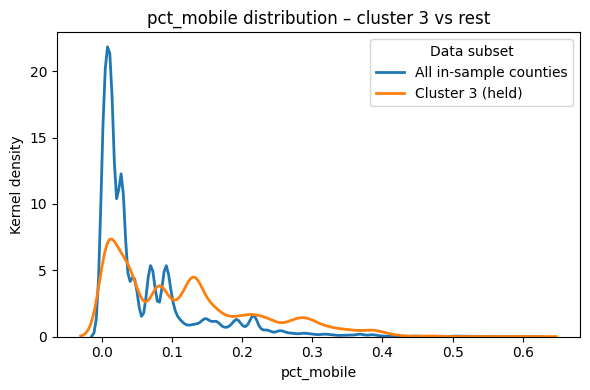

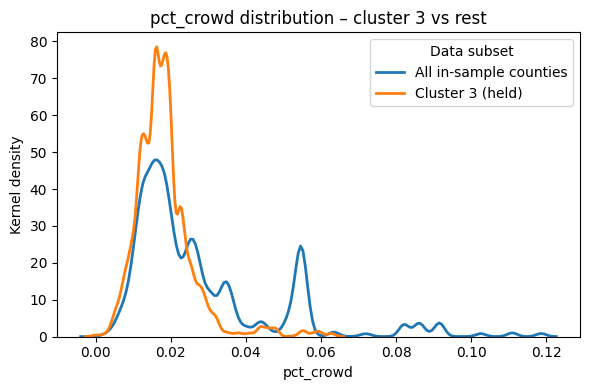

In [15]:
# Pick the primary cluster to inspect
cluster_id = 3                     
held_cluster_df = train_df[train_df['cluster'] == cluster_id]

for col in FEATURES:
    plt.figure(figsize=(6, 4))
    
    sns.kdeplot(
        data=train_df, x=col, label="All in-sample counties",
        bw_adjust=0.7, linewidth=2
    )
    sns.kdeplot(
        data=held_cluster_df, x=col, label=f"Cluster {cluster_id} (held)",
        bw_adjust=0.7, linewidth=2
    )
    
    plt.title(f"{col} distribution – cluster {cluster_id} vs rest")
    plt.xlabel(col)                
    plt.ylabel("Kernel density")  
    plt.legend(title="Data subset")
    plt.tight_layout()
    plt.show()
